In [107]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import seaborn as sns

In [108]:
plt.rcParams["figure.figsize"] = (15,10)

In [109]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [110]:
cols = ['AIR_TEMP', 'WIND_SPEED', 'ATMO_PRESSURE', 'HUMIDITY', 'RAIN_FALL']
colname = ['AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)','HUMIDITY(%)', 'RAIN_FALL(mm)']

In [111]:
def run_Generator(idx):
#   #####################################################
#   ## Loading & Getting predictions from model
#   #####################################################
  df = pd.read_csv(root+'corrected/west_bengal.csv')
  datelist = df['DATE']
  df['DATE']= pd.to_datetime(df['DATE'])
  df = df.drop(columns='DATE')
  training_set = df
  sc = StandardScaler()
  training_set_scaled = sc.fit_transform(training_set)
  sc_predict = StandardScaler()
  sc_predict.fit_transform(training_set.iloc[:, idx:idx+1])
  X_train = []
  y_train = []
  n_future = 1   
  n_past = 60   
  for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, idx])
  X_train, y_train = np.array(X_train), np.array(y_train)
  model = tf.keras.models.load_model(root+'ISRO_MODE/'+cols[idx]+'.h5')
  predictions_train = model.predict(X_train[n_past:])
  y_pred_train = sc_predict.inverse_transform(predictions_train)
  df['DATE'] = datelist 
  y_pred_train[0:].reshape(-1).shape
  hypermodel = tf.keras.models.load_model(root+'ISRO_MODE/SCALERS/'+cols[idx]+'.h5')
  predictions = hypermodel.predict(y_pred_train[0:])
  PREDICTION_TRAIN = pd.DataFrame(predictions, columns=[colname[idx]]).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
  return PREDICTION_TRAIN

In [112]:
genData = run_Generator(4)

In [113]:
predictions = genData.copy()
datelist = genData.index
predictions.describe()

,RAIN_FALL(mm)
count,37866.000000
mean,79.514725
std,93.001770
min,0.865485
25%,9.523447
50%,25.450703
75%,137.802807
max,448.207245


Text(0.5, 0, 'Date')

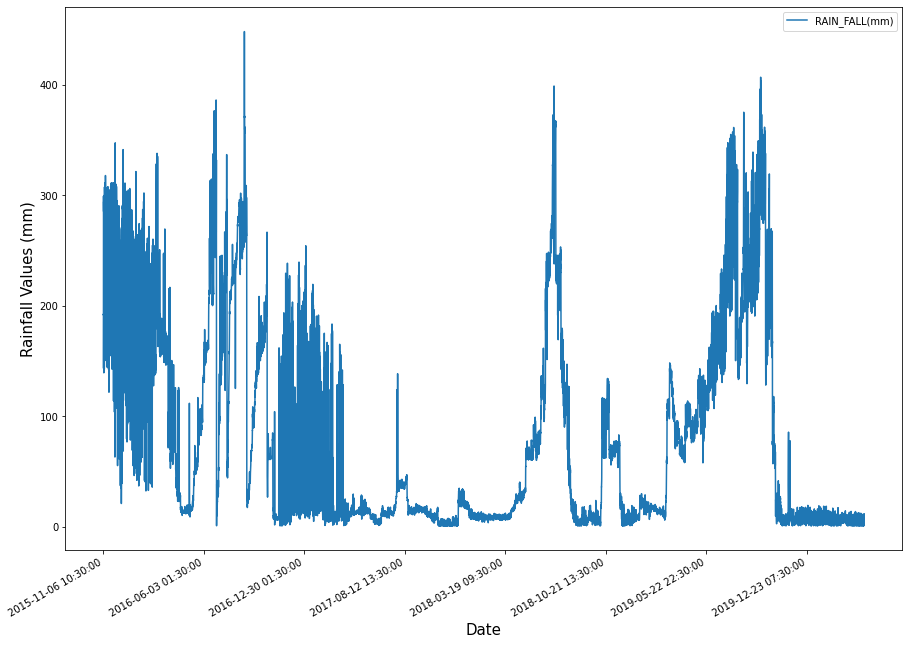

In [114]:
ax = predictions.plot()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ylabel("Rainfall Values (mm)", fontsize = 15)
plt.xlabel("Date", fontsize = 15)

In [115]:
data = predictions['RAIN_FALL(mm)']
delta_plus = np.mean(data) + 1.25 * np.std(data)
delta_minus = np.mean(data) - 1.25 * np.std(data)
print(delta_plus)
print(delta_minus)

195.76540184020996
-36.735952377319336


In [116]:
x_data = np.array(predictions.index)

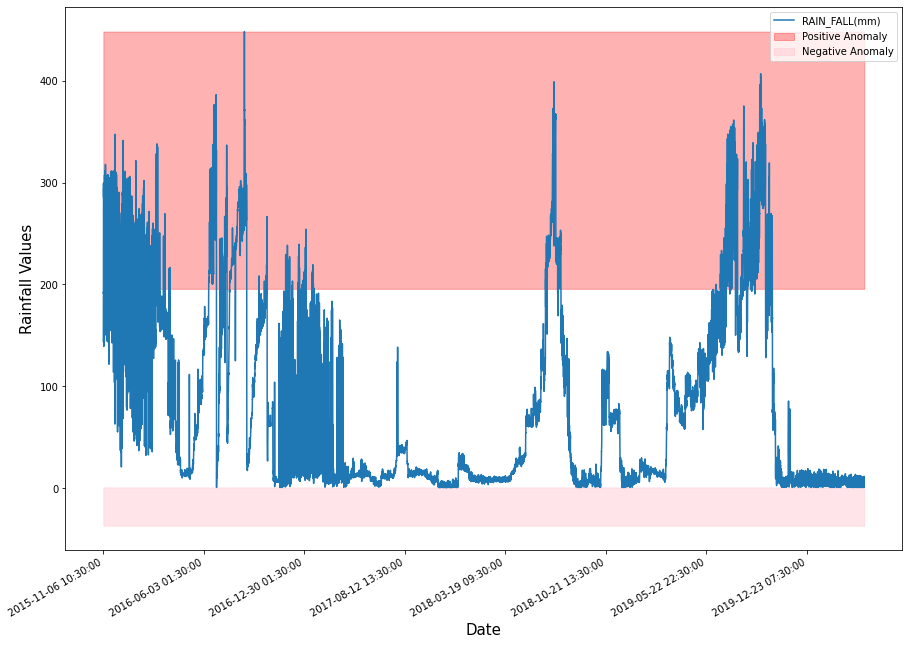

In [117]:
ax = predictions.plot()
ax.fill_between(x_data, max(predictions['RAIN_FALL(mm)']), delta_plus, color = 'red', alpha = 0.3, label='Positive Anomaly')
ax.fill_between(x_data, min(predictions['RAIN_FALL(mm)']), delta_minus, color = 'pink', alpha = 0.4, label='Negative Anomaly')
plt.ylabel("Rainfall Values", fontsize = 15)
plt.xlabel("Date", fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.legend()

In [118]:
df = genData

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


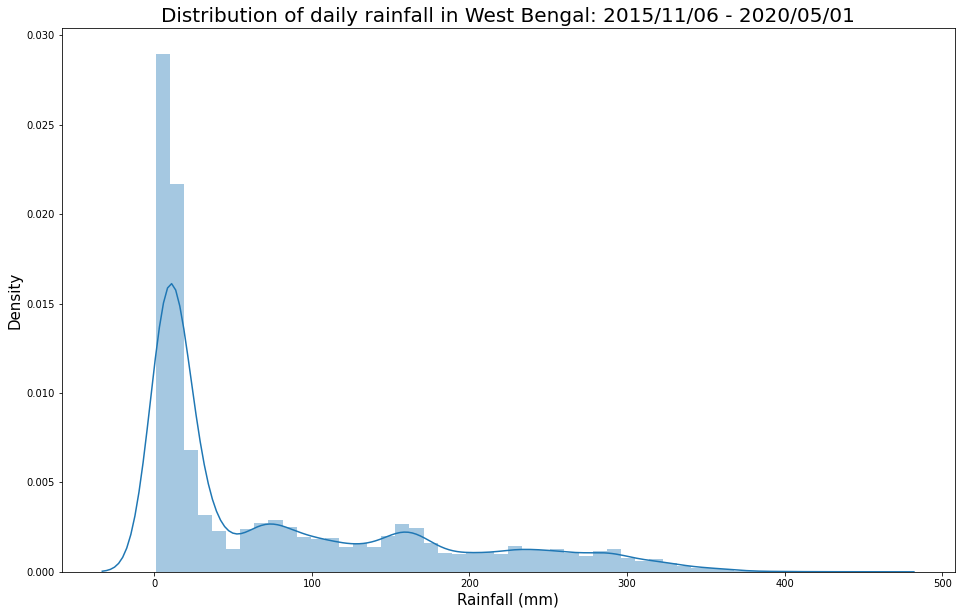

In [119]:
plt.figure(figsize=(16,10))
sns.distplot(df['RAIN_FALL(mm)'])
plt.title('Distribution of daily rainfall in West Bengal: 2015/11/06 - 2020/05/01', fontsize=20)
plt.xlabel("Rainfall (mm)", fontsize=15)
plt.ylabel( "Density",fontsize=15)
plt.show()

In [120]:
print("Skewness: %f" % df['RAIN_FALL(mm)'].skew())
print("Kurtosis: %f" % df['RAIN_FALL(mm)'].kurt())

Skewness: 1.195214
Kurtosis: 0.281429


In [121]:
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
!pip install -U scikit-learn
isolation_forest = IsolationForest( n_estimators=500, n_jobs=-1, random_state=42, contamination=0.1)
isolation_forest.fit(df["RAIN_FALL(mm)"].values.reshape(-1, 1))
rain = np.linspace(
    df["RAIN_FALL(mm)"].min(),
    df["RAIN_FALL(mm)"].max(),
    len(df),
).reshape(-1, 1)

anomaly_score_rain = isolation_forest.decision_function(rain)

outlier_rain = isolation_forest.predict(rain)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


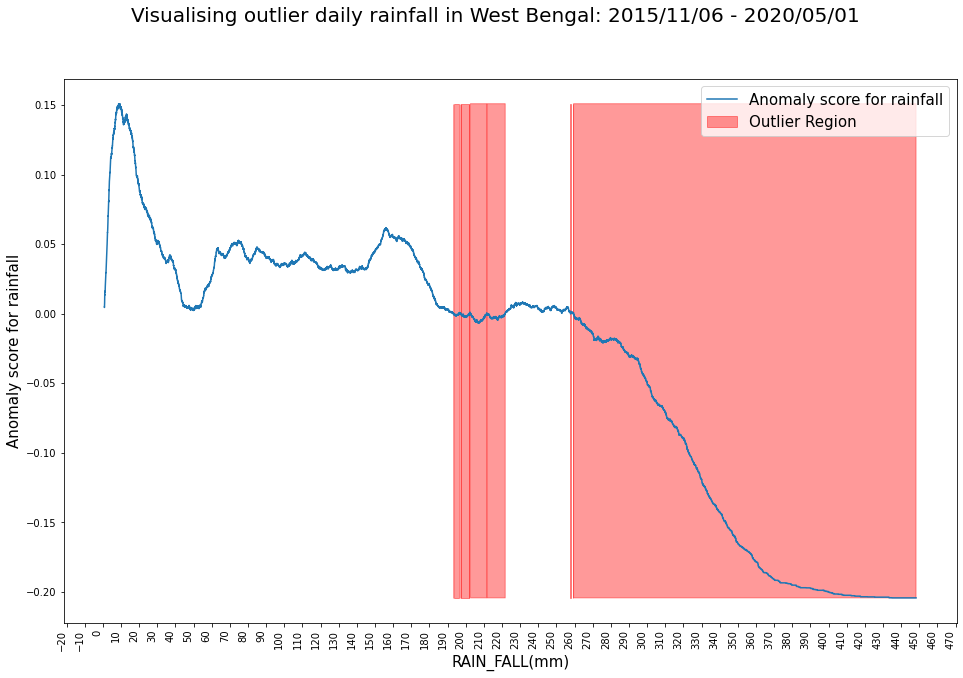

In [122]:
plt.figure(figsize=(16, 10))
plt.plot(rain, anomaly_score_rain, label="Anomaly score for rainfall")
plt.fill_between(
    rain.T[0],
    np.min(anomaly_score_rain),
    np.max(anomaly_score_rain),
    where=outlier_rain == -1,
    color="r",
    alpha=0.4,
    label="Outlier Region",
)
plt.legend(fontsize=15)
plt.ylabel("Anomaly score for rainfall", fontsize=15)
plt.xlabel("RAIN_FALL(mm)", fontsize=15)
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

plt.suptitle("Visualising outlier daily rainfall in West Bengal: 2015/11/06 - 2020/05/01", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

In [123]:
# finding where the outlier region begins
idx = np.argwhere(np.diff(np.sign(anomaly_score_rain))).flatten()
rain[idx]

array([[193.1757759 ],
       [193.18759002],
       [193.35298774],
       [196.24744783],
       [196.94448107],
       [196.97992344],
       [197.22802002],
       [197.39341774],
       [197.40523186],
       [202.036368  ],
       [202.04818213],
       [202.07181037],
       [202.6034459 ],
       [211.52310861],
       [211.75939107],
       [221.77776721],
       [257.68088641],
       [257.79902764],
       [259.16946588],
       [259.2285365 ],
       [259.44119071]])

In [124]:
df[df["RAIN_FALL(mm)"] > 193.1757759].count()[0]

5677

In [125]:
idx

array([16278, 16279, 16293, 16538, 16597, 16600, 16621, 16635, 16636,
       17028, 17029, 17031, 17076, 17831, 17851, 18699, 21738, 21748,
       21864, 21869, 21887])

In [126]:
rain_data = df.loc[df['RAIN_FALL(mm)'] > 193.1757759]
orig_rain_data = pd.read_csv(root+'corrected/west_bengal.csv')[['RAIN_FALL(mm)', 'DATE']][2 * 60 + 1 -1:]


In [127]:
orig_rain_data

,RAIN_FALL(mm),DATE
120,150.5,2015-11-06 10:30:00
121,150.5,2015-11-06 11:30:00
122,150.5,2015-11-06 12:30:00
123,150.5,2015-11-06 13:30:00
124,150.5,2015-11-06 14:30:00
...,...,...
37981,0.0,2020-04-30 23:30:00
37982,0.5,2020-05-01 00:30:00
37983,0.0,2020-05-01 01:30:00
37984,0.0,2020-05-01 02:30:00


In [128]:
print(rain_data.head())
print(orig_rain_data.head())

                     RAIN_FALL(mm)
DATE                              
2015-11-06 16:30:00     283.896729
2015-11-06 17:30:00     293.971313
2015-11-06 18:30:00     299.226929
2015-11-06 19:30:00     297.976410
2015-11-06 20:30:00     295.709076
     RAIN_FALL(mm)                 DATE
120          150.5  2015-11-06 10:30:00
121          150.5  2015-11-06 11:30:00
122          150.5  2015-11-06 12:30:00
123          150.5  2015-11-06 13:30:00
124          150.5  2015-11-06 14:30:00


In [129]:
orig_rain_data = orig_rain_data[orig_rain_data.DATE.isin(rain_data.index)]

In [130]:
rain_data['Year'] = pd.DatetimeIndex(rain_data.index).year
rain_data['Month'] = pd.DatetimeIndex(rain_data.index).month
rain_data
orig_rain_data['Year'] = pd.DatetimeIndex(orig_rain_data.DATE).year
orig_rain_data['Month'] = pd.DatetimeIndex(orig_rain_data.DATE).month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Text(0, 0.5, 'Number of days with outlier weather')

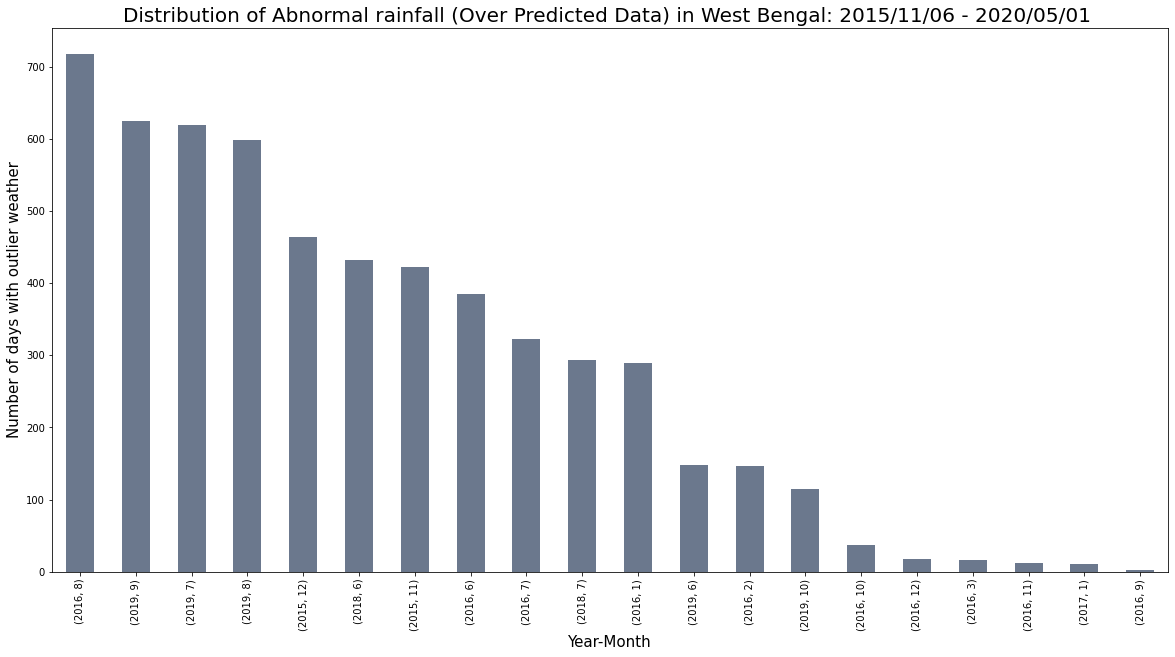

In [144]:
ax = rain_data.groupby(["Year"]).Month.value_counts().sort_values(
    ascending=False
).head(20).plot(kind="bar", 
                figsize=(20, 10),
               color='#6B788D')
plt.title(
    "Distribution of Abnormal rainfall (Over Predicted Data) in West Bengal: 2015/11/06 - 2020/05/01 ",
    fontsize=20,
)

plt.xlabel("Year-Month", fontsize=15)
plt.ylabel("Number of days with outlier weather", fontsize=15)
# plt.show()

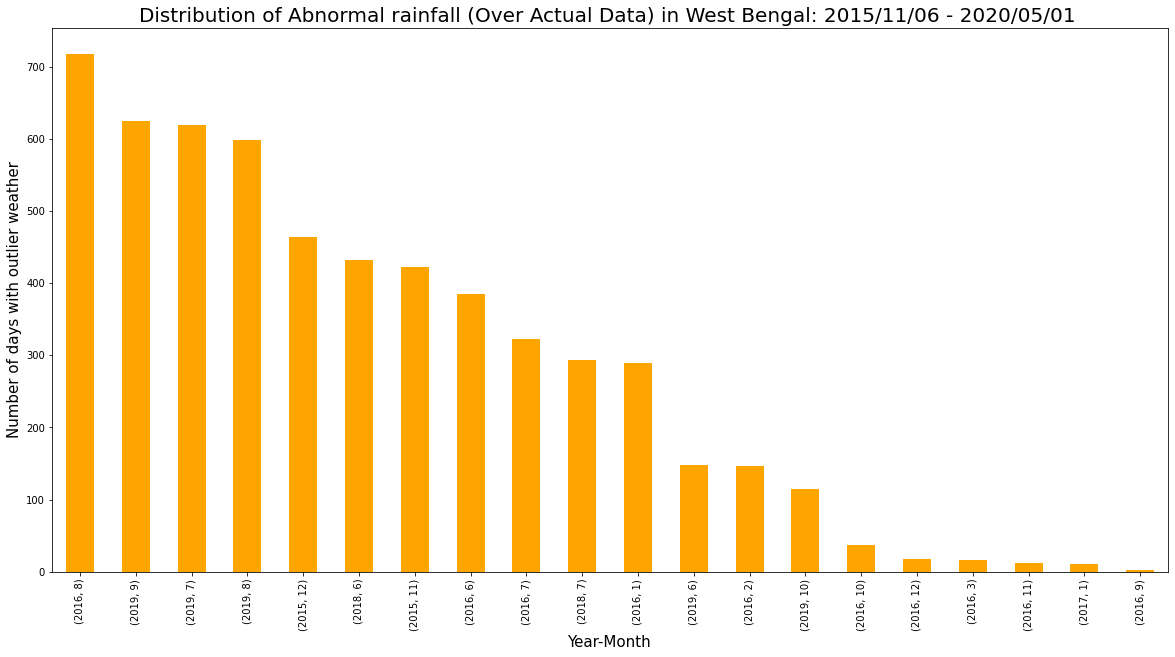

In [145]:
ax = orig_rain_data.groupby(["Year"]).Month.value_counts().sort_values(
    ascending=False
).head(20).plot(kind="bar", 
                figsize=(20, 10),
               color='orange')
plt.title(
    "Distribution of Abnormal rainfall (Over Actual Data) in West Bengal: 2015/11/06 - 2020/05/01 ",
    fontsize=20,
)

plt.xlabel("Year-Month", fontsize=15)
plt.ylabel("Number of days with outlier weather", fontsize=15)
plt.show()

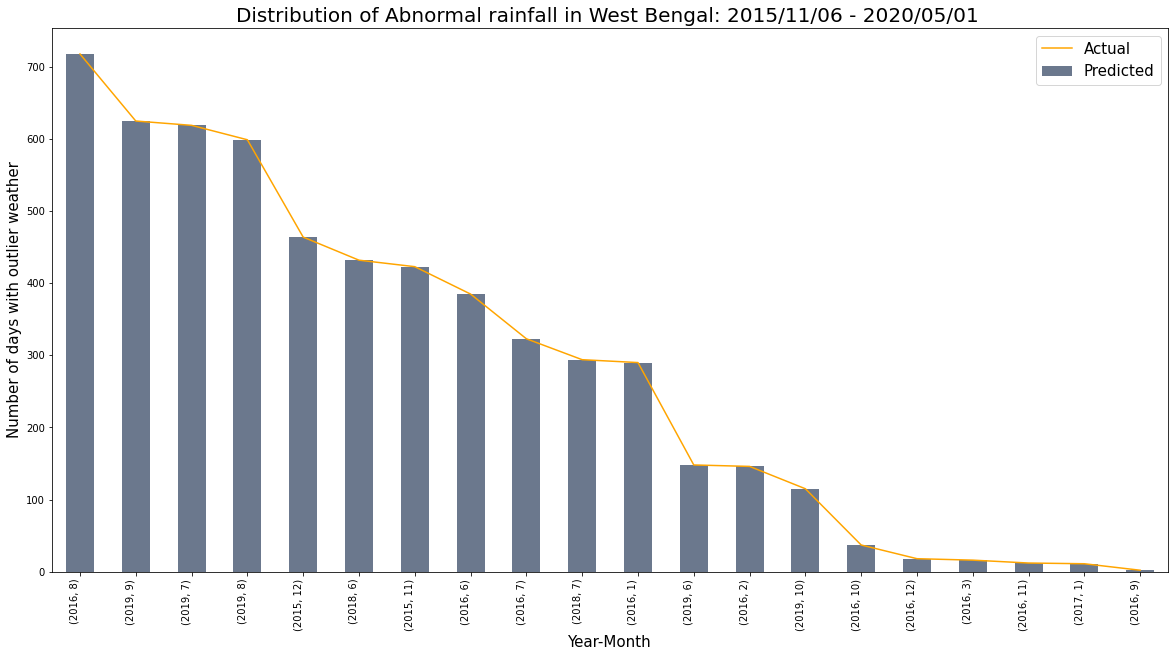

In [154]:
ax = rain_data.groupby(["Year"]).Month.value_counts().sort_values(
    ascending=False
).head(20).plot(kind="bar", 
                figsize=(20, 10),
               color='#6B788D', legend = ['Predicted'])

ax1 = orig_rain_data.groupby(["Year"]).Month.value_counts().sort_values(
    ascending=False
).head(20).plot(kind="line", 
                figsize=(20, 10),
               color='orange', legend = ['Actual'])

plt.title(
    "Distribution of Abnormal rainfall in West Bengal: 2015/11/06 - 2020/05/01 ",
    fontsize=20,
)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.xlabel("Year-Month", fontsize=15)
plt.ylabel("Number of days with outlier weather", fontsize=15)
plt.legend(['Actual', 'Predicted'], fontsize = 15)
plt.show()